In [2]:
import numpy as np, torch, matplotlib.pyplot as plt, pytorch_lightning
from tqdm.auto import tqdm

from os.path import join, basename, dirname, expanduser
import sys
sys.path.append('../src')
import gta.recording_videos

In [25]:
import PIL.Image

In [3]:
# data = gta.recording_videos.find_filenames(base_dir=join(gta.recording_videos.HOME, 'data', 'gta', 'velocity_prediction', 'Protocol V1'))
data = gta.recording_videos.find_filenames(base_dir=join(gta.recording_videos.HOME, 'data', 'gta', 'velocity_prediction', 'Protocol V2'))

Found 5 image recording(s) in C:\Users\tsbertalan\data\gta\velocity_prediction\Protocol V2.
Found 6 telemetry recording(s) in C:\Users\tsbertalan\data\gta\velocity_prediction\Protocol V2.


Pairing data files: 100%|██████████| 5/5 [00:00<?, ?npz file/s]

Image archive 2021-09-25-17-08-10-gtav_recording.npz is in known.json.
Image archive 2021-09-25-19-06-29-gtav_recording.npz is in known.json.
Image archive 2021-09-25-19-15-25-gtav_recording.npz is in known.json.
Image archive 2021-09-26-15-57-01-gtav_recording.npz is in known.json.
Image archive 2021-09-26-16-10-48-gtav_recording.npz is in known.json.


In [6]:
from gta.recording_videos import ImageRecording, TelemetryRecording

def show_pairing_times(pairing, show_player_vehs=True):
    fig, ax = plt.subplots()
    labels = []
    Y = []
    X = []
    for i, item in enumerate([pairing.image_recording] + list(pairing.telemetry_recordings)):
        Y.append([i, i])
        
        if isinstance(item, ImageRecording):
            if len(item.times):
                t1, t2 = item.tmin, item.tmax
            else:
                t1, t2 = None, None
        else:
            t1, t2 = item.track_manager.tmin, item.track_manager.tmax
        X.append([t1, t2])
        bn = basename(item.fname)
        labels.append(bn)
        color = 'red' if isinstance(item, ImageRecording) else 'black'
        ax.plot(
            X[-1], Y[-1], linestyle='-', 
            color=color, linewidth=1,
        )
        if isinstance(item, TelemetryRecording) and show_player_vehs:
            player_vehs = [track for track in item.track_manager.tracks if track.is_player and track.is_vehicle]
            for pv in tqdm(player_vehs):
                if pv.duration < 1:
                    continue
                ax.plot(
                    [pv.tmin, pv.tmax], Y[-1],
                    color=color, linestyle='-',
                    alpha=0.25, linewidth=6, marker='|', markersize=10,
                )
    ax.set_yticks([y[0] for y in Y])
    ax.set_yticklabels(labels)
    ax.set_xlabel('wall_time')
    ax.set_title('Recordings paired with %s' % basename(pairing.image_recording.fname))

Loading ImageRecording("C:\Users\tsbertalan\data\gta\velocity_prediction\Protocol V2\2021-09-26-15-57-01-gtav_recording.npz")


________________________________________________________________________________
[Memory] Calling gta.read_entitystate_data.read_data...
read_data(('C:\\Users\\tsbertalan\\data\\gta\\velocity_prediction\\Protocol '
 'V2\\GTA_recording-422397.bin'))
Protocol version: 2


Reading loaded file: 100%|█████████▉| 44295/44296 [00:17<00:00, 2534.11kbytes/s]


Persisting in C:\Users\tsbertalan\data\gta\velocity_prediction\joblib\gta\read_entitystate_data\read_data\d93b1a49bf80b4447ad442aabf6a5d93
_______________________________________________________read_data - 17.8s, 0.3min


100%|██████████| 293/293 [00:00<00:00, 7918.93it/s]


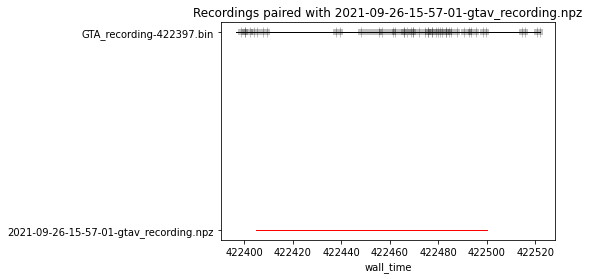

In [7]:
pairing = data['paired'][-2]
show_pairing_times(pairing)

In [8]:
telemetry_recording = pairing.telemetry_recordings[0]

In [9]:
len([pv.duration for pv in [track for track in telemetry_recording.track_manager.tracks 
                 if track.is_player and track.is_vehicle]])

293

In [11]:
telemetry_recording.track_manager.merge_player_tracks()
player_tracks = [track for track in telemetry_recording.track_manager.tracks 
                 if track.is_player and track.is_vehicle]
len([pv.duration for pv in player_tracks])

1

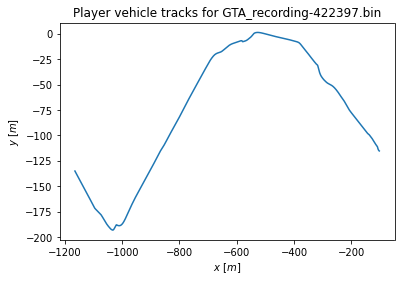

In [12]:
fig, ax = plt.subplots()
for pv in player_tracks:
    ax.plot(pv._get_data('posx'), pv._get_data('posy'))
ax.set_xlabel('$x$ $[m]$')
ax.set_ylabel('$y$ $[m]$')
ax.set_title('Player vehicle tracks for %s' % basename(telemetry_recording.fname));

In [13]:
import train_velocity_predictor

In [18]:
imgs = pairing.image_recording.images
times = pairing.image_recording.times
len(imgs), len(times)

(537, 537)

In [120]:
i1 = 100
i2 = i1 + 1

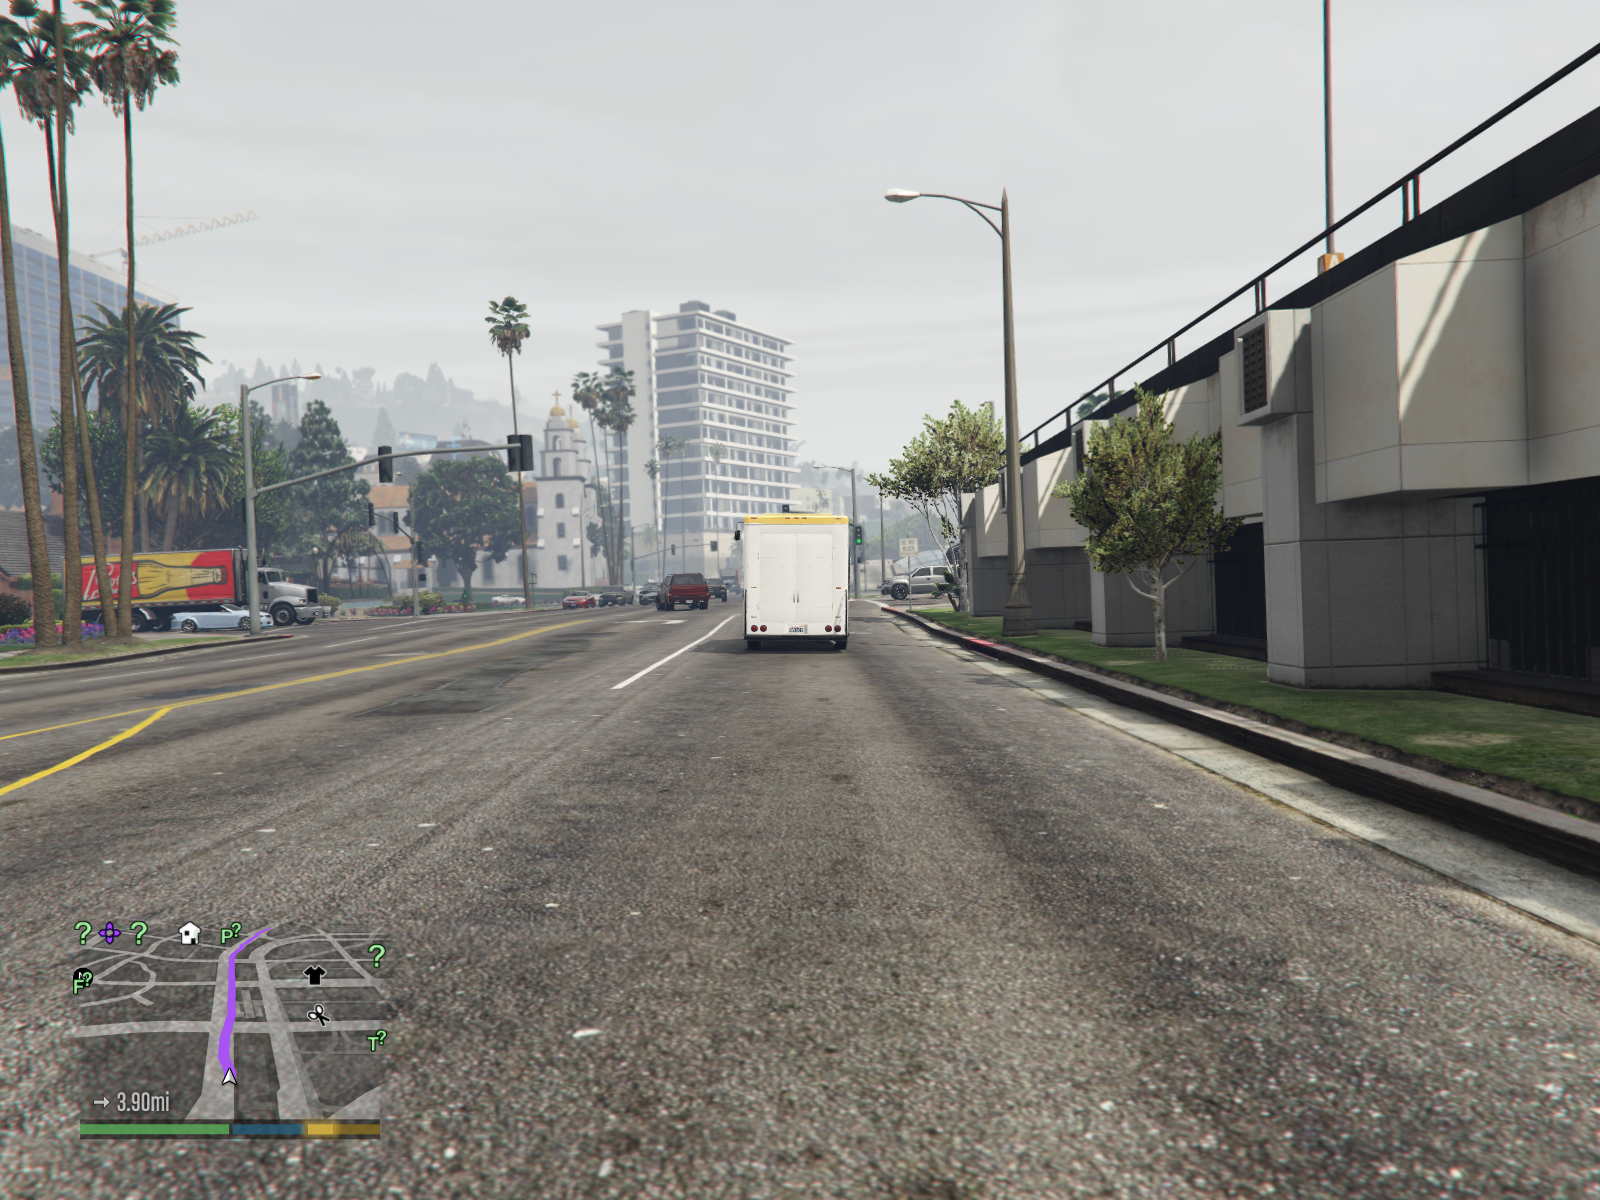

In [121]:
PIL.Image.fromarray(imgs[i1])

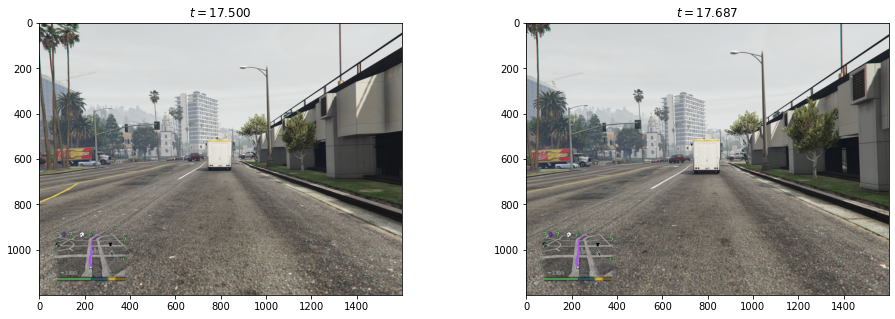

In [122]:
img1 = imgs[i1]
img2 = imgs[i2]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
ax.imshow(img1)
ax.set_title('$t=%.3f$' % (times[i1] - times[0]))
bx.imshow(img2, cmap='inferno')
bx.set_title('$t=%.3f$' % (times[i2] - times[0]));

In [123]:
flow = train_velocity_predictor.convert_image_pair_to_optical_flow(imgs[i1], imgs[i2])

In [124]:
flow.max()

283.89526

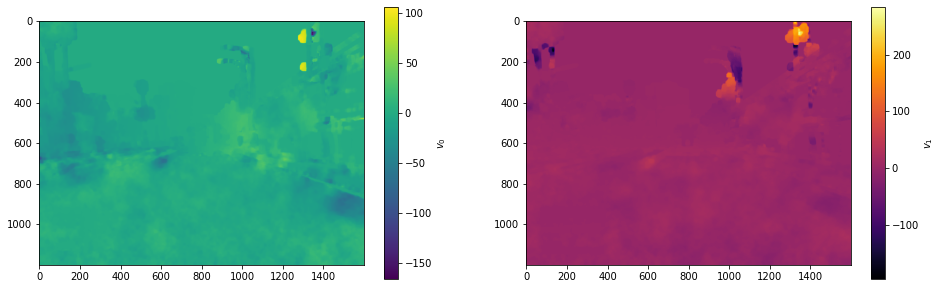

In [125]:
img1 = flow[..., 0]
img2 = flow[..., 1]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
fig.colorbar(ax.imshow(img1), ax=ax, label='$v_0$')
fig.colorbar(bx.imshow(img2, cmap='inferno'), ax=bx, label='$v_1$')

In [126]:
logf = np.log10(flow)
nan_spots = np.isnan(logf)
low_spots = logf == -np.inf
high_spots = logf == np.inf
ok_places = np.logical_and(
    np.logical_not(np.isnan(logf)),
    np.logical_not(np.isinf(logf))
)
logf.min(), logf.max()
logf[np.logical_not(nan_spots)].min(), logf[np.logical_not(nan_spots)].max()

<ipython-input-126-a2e87d80c39d>:1: RuntimeWarning: invalid value encountered in log10
  logf = np.log10(flow)


(-25.627504, 2.4531581)

In [127]:
lowlog = np.min(logf[ok_places])
highlog = np.max(logf[ok_places])
logf[low_spots] = lowlog
logf[high_spots] = highlog
logf[nan_spots] = lowlog

In [128]:
logf[ok_places].min(), logf[ok_places].max()

(-25.627504, 2.4531581)

In [129]:
# logf_uint8 = ((logf - logf[ok_places].min()) / (logf[ok_places].max() - logf[ok_places].min()) * 255).astype(np.uint8)

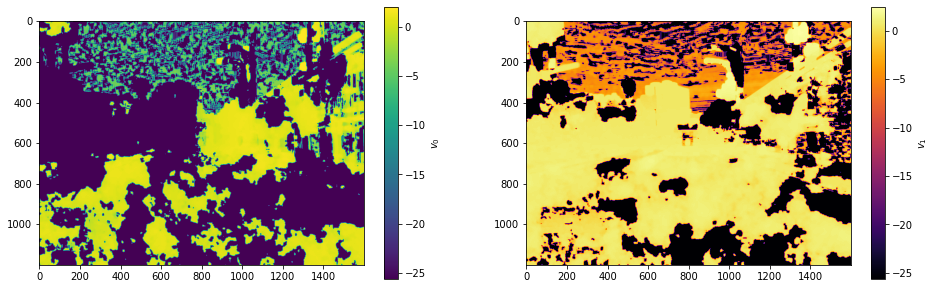

In [130]:
img1 = logf[..., 0]
img2 = logf[..., 1]
fig, (ax, bx) = plt.subplots(ncols=2, figsize=(16, 5))
fig.colorbar(ax.imshow(img1), ax=ax, label='$v_0$')
fig.colorbar(bx.imshow(img2, cmap='inferno'), ax=bx, label='$v_1$')